[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.

## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [45]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Default overwriting state

Let's use a `TypedDict` as our state schema.

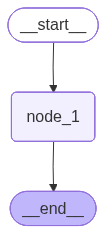

In [46]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define state schema
class State(TypedDict):
    bar: int  # changed foo -> bar

# Define node
def node_1(state):
    print("---Node 1---")
    return {"bar": state['bar'] + 1}  # changed foo -> bar

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Graph logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile graph
graph = builder.compile()

# Visualize graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [47]:
graph.invoke({"bar" : 1})

---Node 1---


{'bar': 2}

Let's look at the state update, `return {"bar": state['bar'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.

So, it will just overwrite the value of `bar` in `node_1`:

```
return {"bar": state['bar'] + 1}
```

If we pass `{'bar': 1}` as input, the state returned from the graph is `{'bar
': 2}`.

## Branching

Let's look at a case where our nodes branch.

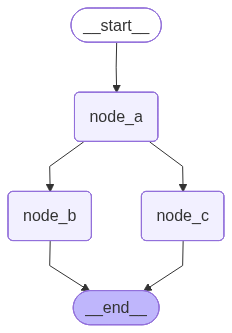

In [48]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display

# Define the state schema with a reducer
# We annotate "bar" so updates are combined (not overwritten)
class State(TypedDict):
    bar: Annotated[int, add_messages]  # you can replace add_messages with a custom reducer later

# Define nodes
def node_a(state):
    print("---Node A---")
    return {"bar": state["bar"] * 2}   # Multiply value

def node_b(state):
    print("---Node B---")
    return {"bar": state["bar"] + 5}   # Add constant value

def node_c(state):
    print("---Node C---")
    return {"bar": state["bar"] - 3}   # Subtract constant value

# Build graph
builder = StateGraph(State)
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

# Graph logic
builder.add_edge(START, "node_a")
builder.add_edge("node_a", "node_b")
builder.add_edge("node_a", "node_c")
builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

# Compile graph
graph = builder.compile()

# Visualize graph
display(Image(graph.get_graph().draw_mermaid_png()))


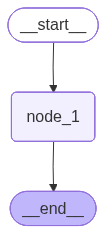

---Node 1---
Final State: {'bar': [1, 2]}
---Node 1---
Final State: {'bar': [5, 10, 6]}


In [59]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.errors import InvalidUpdateError

# Custom reducer that safely merges lists even if one is None
def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

# State with safe reducer
class CustomReducerState(TypedDict):
    bar: Annotated[list[int], reduce_list]

# Node definition
def node_1(state):
    print("---Node 1---")
    # Safely handle empty or None list
    current = state["bar"][0] if state["bar"] else 0
    return {"bar": [current + 1]}

# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Graph logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile graph
graph = builder.compile()

# Visualize graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Safe invocation wrapper
def safe_invoke(graph, state_update):
    """Ensure bar is a list before invoking the graph."""
    if "bar" in state_update and not isinstance(state_update["bar"], list):
        state_update["bar"] = [state_update["bar"]]
    try:
        result = graph.invoke(state_update)
        print("Final State:", result)
    except InvalidUpdateError as e:
        print(f"InvalidUpdateError occurred: {e}")

# Example invocations
safe_invoke(graph, {"bar": 1})      # single int, automatically converted to list
safe_invoke(graph, {"bar": [5, 10]})  # list works as-is



We see a problem!

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*.

This is ambiguous for the graph! Which state should it keep?

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function.

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

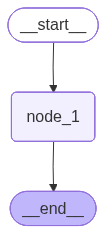

In [57]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Define custom reducer that appends new values instead of overwriting
def merge_lists(x, y):
    return x + y  # simple list concatenation

# Define the state schema
class State(TypedDict):
    bar: Annotated[list[int], merge_lists]  # changed foo -> bar

# Define node
def node_1(state):
    print("---Node 1---")
    return {"bar": [state["bar"][0] + 1]}  # changed foo -> bar

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Graph logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile and visualize
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [56]:
graph.invoke({"bar": [1]})


---Node 1---
---Node 2---
---Node 3---


{'bar': [1, 2, 4, 5]}

Now, our state key `bar` is a list.

This `operator.add` reducer function will append updates from each node to this list.

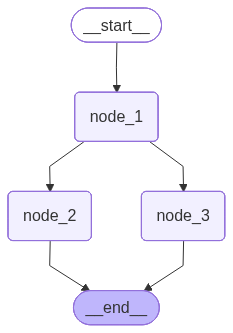

---Node 1---
---Node 2---
---Node 3---
Final State: {'bar': [0, 1, 3, 4]}


In [55]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Reducer function for merging parallel updates
def merge_lists(x, y):
    return x + y  # append instead of overwrite

# Define state schema
class State(TypedDict):
    bar: Annotated[list[int], merge_lists]

# Define nodes
def node_1(state):
    print("---Node 1---")
    return {"bar": [state["bar"][-1] + 1]}  # increment last value

def node_2(state):
    print("---Node 2---")
    return {"bar": [state["bar"][-1] + 2]}  # different increment

def node_3(state):
    print("---Node 3---")
    return {"bar": [state["bar"][-1] + 3]}  # different increment

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Graph logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile and visualize
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# Run the graph
result = graph.invoke({"bar": [0]})
print("Final State:", result)


We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [54]:
graph.invoke({"bar" : [1]})

---Node 1---


{'bar': [2]}

Now, let's see what happens if we pass `None` to `bar`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`.

In [53]:
try:
    graph.invoke({"bar" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

---Node 1---


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state).

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [52]:
from typing import Annotated
from typing_extensions import TypedDict

# Custom reducer that safely merges lists even if one is None
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None."""
    if not left:
        left = []
    if not right:
        right = []
    return left + right

# Default state using standard addition (for example)
class DefaultState(TypedDict):
    bar: Annotated[list[int], list.__add__]  # changed foo -> bar

# Custom reducer state using safe reducer
class CustomReducerState(TypedDict):
    bar: Annotated[list[int], reduce_list]  # changed foo -> bar


In `node_1`, we append the value 2.

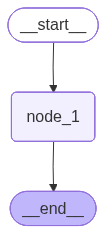

---Node 1---
{'bar': [2]}


In [51]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Define initial state schema
class State(TypedDict):
    bar: list[int]  # bar will store a list of integers

# Define node
def node_1(state):
    print("---Node 1---")
    return {"bar": [2]}  # returning list with a value

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Graph logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile graph
graph = builder.compile()

# Visualize graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Run graph safely
try:
    print(graph.invoke({"bar": [0]}))  # provide initial value
except TypeError as e:
    print(f"TypeError occurred: {e}")


Now, try with our custom reducer. We can see that no error is thrown.

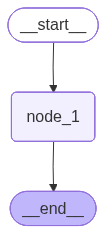

---Node 1---
Final State: {'bar': [1]}


In [50]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Custom reducer that safely merges lists even if one is None
def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

# State with safe reducer
class CustomReducerState(TypedDict):
    bar: Annotated[list[int], reduce_list]

# Node definition
def node_1(state):
    print("---Node 1---")
    current = state["bar"][0] if state["bar"] else 0  # handle None
    return {"bar": [current + 1]}

# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Graph logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile graph
graph = builder.compile()

# Visualize graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Invoke graph safely
try:
    result = graph.invoke({"bar": None})
    print("Final State:", result)
except TypeError as e:
    print(f"TypeError occurred: {e}")


## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate).

* `MessagesState` has a built-in `messages` key
* It also has a built-in `add_messages` reducer for this key

These two are equivalent.

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [ ]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/).

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [ ]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="jance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

In [ ]:
add_messages(messages , delete_messages)

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.